In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import torch
# import torch.nn.functional as F#for relu
from tensorflow.keras.datasets import fashion_mnist
(x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)
x_train = x_train.reshape(x_train.shape[0],-1)/255 #Creates 60000 rows of 784 coloumn wide Matrix
x_test = x_test.reshape(x_test.shape[0],-1)/255#Creates 60000 rows of 784 coloumn wide Matrix
y_train_encoded = np.eye(10)[y_train]
y_test_encoded = np.eye(10)[y_test]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
class Neural_Network:
    def __init__(self, inputsize, hiddensize, outputsize, lr=0.01, l1_lambda=0.01, l2_lambda=0.01, dropout_rate=0.5, alpha=0.5):
        self.inputsize = inputsize
        self.hiddensize = hiddensize
        self.outputsize = outputsize
        self.lr = lr
        self.l1_lambda = l1_lambda  # L1 regularization factor (Lasso)
        self.l2_lambda = l2_lambda  # L2 regularization factor (Ridge)
        self.alpha = alpha  # Mix between L1 and L2 regularization
        self.dropout_rate = dropout_rate

        # Initialize weights and biases
        self.W1 = np.random.randn(self.inputsize, self.hiddensize) * np.sqrt(2.0 / inputsize)
        self.b1 = np.zeros((1, self.hiddensize))
        self.W2 = np.random.randn(self.hiddensize, self.outputsize) * np.sqrt(2.0 / hiddensize)
        self.b2 = np.zeros((1, self.outputsize))

        self.loss_history = []

    def apply_dropout(self, layer_output, dropout_rate):
        dropout_mask = np.random.binomial(1, 1 - dropout_rate, size=layer_output.shape)
        return layer_output * dropout_mask / (1 - dropout_rate), dropout_mask

    def relu(self, Z):
        """ReLU activation function"""
        return np.maximum(0, Z)

    def softmax(self, Z):
        """Softmax function"""
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # Stability improvement by subtracting max(Z)
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def apply_dropout(self, layer_output, dropout_rate):
        """Applies dropout"""
        dropout_mask = np.random.binomial(1, 1 - dropout_rate, size=layer_output.shape)
        return layer_output * dropout_mask / (1 - dropout_rate), dropout_mask

    def forward(self, X, training=True):
        """Forward pass"""
        # First layer forward pass
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)  # Apply ReLU

        # Apply dropout only during training
        if training:
            self.a1, self.dropout_mask = self.apply_dropout(self.a1, self.dropout_rate)

        # Second layer forward pass
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)  # Apply softmax
        return self.a2
    def backward(self, X, y, output):
        m = X.shape[0]
        dz2 = output - y  # Gradient of the loss with respect to z2 (output layer pre-activation)

        # Gradients for W2 and b2
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * (self.z1 > 0)  # Backprop through ReLU
        dz1 *= self.dropout_mask  # Apply dropout mask during backpropagation

        # Gradients for W1 and b1
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Apply ElasticNet regularization
        dW1 += self.alpha * self.l1_lambda * np.sign(self.W1) + (1 - self.alpha) * self.l2_lambda * self.W1
        dW2 += self.alpha * self.l1_lambda * np.sign(self.W2) + (1 - self.alpha) * self.l2_lambda * self.W2

        # Update weights and biases
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def train(self, X, y, epochs):
        for epoch in range(epochs):
            output = self.forward(X, training=True)  # Forward pass with dropout
            self.backward(X, y, output)  # Backpropagation

            # Calculate loss with ElasticNet regularization penalty
            penalty = self.alpha * self.l1_lambda * (np.sum(np.abs(self.W1)) + np.sum(np.abs(self.W2))) + \
                      (1 - self.alpha) * self.l2_lambda * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))

            # Cross-entropy loss
            loss = -np.mean(np.sum(y * np.log(output + 1e-10), axis=1)) + penalty
            self.loss_history.append(loss)

            if epoch % 1 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        output = self.forward(X, training=False)
        return np.argmax(output, axis=1)

In [20]:
nn_elasticnet = Neural_Network(inputsize=784, hiddensize=64, outputsize=10, lr=0.01, l1_lambda=0.001, l2_lambda=0.001, dropout_rate=0.5, alpha=0.5)
nn_elasticnet.train(x_train, y_train_encoded, epochs=1000)

Epoch 0, Loss: 3.5881
Epoch 1, Loss: 3.5625
Epoch 2, Loss: 3.5380
Epoch 3, Loss: 3.5173
Epoch 4, Loss: 3.4995
Epoch 5, Loss: 3.4788
Epoch 6, Loss: 3.4611
Epoch 7, Loss: 3.4492
Epoch 8, Loss: 3.4349
Epoch 9, Loss: 3.4201
Epoch 10, Loss: 3.4095
Epoch 11, Loss: 3.3924
Epoch 12, Loss: 3.3832
Epoch 13, Loss: 3.3752
Epoch 14, Loss: 3.3668
Epoch 15, Loss: 3.3540
Epoch 16, Loss: 3.3424
Epoch 17, Loss: 3.3355
Epoch 18, Loss: 3.3278
Epoch 19, Loss: 3.3225
Epoch 20, Loss: 3.3134
Epoch 21, Loss: 3.3043
Epoch 22, Loss: 3.2977
Epoch 23, Loss: 3.2908
Epoch 24, Loss: 3.2836
Epoch 25, Loss: 3.2767
Epoch 26, Loss: 3.2701
Epoch 27, Loss: 3.2657
Epoch 28, Loss: 3.2566
Epoch 29, Loss: 3.2522
Epoch 30, Loss: 3.2470
Epoch 31, Loss: 3.2385
Epoch 32, Loss: 3.2351
Epoch 33, Loss: 3.2289
Epoch 34, Loss: 3.2255
Epoch 35, Loss: 3.2178
Epoch 36, Loss: 3.2118
Epoch 37, Loss: 3.2077
Epoch 38, Loss: 3.2016
Epoch 39, Loss: 3.1990
Epoch 40, Loss: 3.1902
Epoch 41, Loss: 3.1897
Epoch 42, Loss: 3.1821
Epoch 43, Loss: 3.178

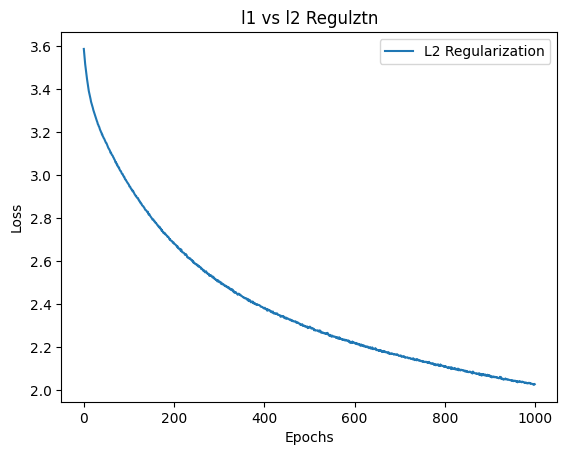

In [21]:
# plt.plot(nn_l1.loss_history, label='L1 Regularization')
plt.plot(nn_elasticnet.loss_history, label='L2 Regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('l1 vs l2 Regulztn')
plt.legend()
plt.show()

In [22]:
predictions = nn_elasticnet.predict(x_test)
accuracy = np.mean(predictions == y_test)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.7298
